In [1]:
import torch
import diffusers
import transformers

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
modelid = "runwayml/stable-diffusion-v1-5"
other = "darkstorm2150/Protogen_x3.4_Official_Release"

In [3]:
pipe = diffusers.DiffusionPipeline.from_pretrained(other, custom_pipeline="./").to("cuda").to(torch.float16)
#pipe = diffusers.StableDiffusionPipeline.from_pretrained(modelid).to("cuda").to(torch.float16)
pipe.safety_checker = None


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [4]:
from p2p.EDICT import do_inversion
from p2p.feat_share import register_res_control, FeatControl
from p2p.ptp_utils import register_attention_control, get_schedule
from p2p.prompt2prompt import make_controller
from p2p.prompt2prompt import LocalBlend
from p2p.parse_prompt import get_weighted_text_embeddings
from p2p.prompt2prompt import get_equalizer

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [7]:
from PIL import Image

register_attention_control(pipe, None)
# to do inversion we need the default attn methods, so we call that line

# these params do well, we can improve if we do begin inversion at half noise level (x_T/2) for example rather than x0, but i've botched it for now
init_image = Image.open("./david.jpeg").convert("RGB").resize((768,768))
latents = do_inversion(pipe, init_image, prompts[0], 
                       height=768, width=768,
                       end_noise=1.0,
                       begin_noise=0.0,
                       steps=50,
                       mix_weight=1.0, guidance_scale=1.0)

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
prompts = ["a statue of a man", "a statue of a (cyborg:7) in a (cyberpunk:7) universe"]

steps= 50

#blend_words = ((('person',), ("cyborg",)))
#blend_words = (("person"),("robot")) # OPTIONAL first word doesn't matter from how i've reworked it, 2nd word is the area you want to edit
#substruct_words = (("person"),("dog"))

# in the future, rather than doing
#this goofy method of weighting words, we can just borrow the parse_prompt code
i, k, eq = get_weighted_text_embeddings(pipe, prompts[1])
eof = torch.where(k==49407)[1][0].item() # find first end of phrase tokens

parsed_prompt = pipe.tokenizer.batch_decode(k[:,1:eof])[0]

prompts[1] = parsed_prompt

# these allow us to inject blend of original features with proposed features
# value of 1 is purely the original features, 0 is purely new
# buffer is number of steps for which we hold a constant value specified by start buffer value
# from there it linearly interpolates from start to end value
# cross i wouldn't mess with a ton
cross_schedule = {
    "start": 1.0, 
    "end": 0.7, 
    "start_buffer":0,
    "start_buffer_value":1.0,
}

# can try lowering start/start_buffer_value a tad, 
# but biggest thing to experiment with is the end value for which 0.2-0.7 are interesting
self_schedule = {
    "start": 1.0, 
    "end": 0.45, 
    "start_buffer":10,
    "start_buffer_value":1.0,
}
conv_schedule = {
    "start": 1.0, 
    "end": 0.45, 
    "start_buffer":9,
    "start_buffer_value":1.0,
}

# all of the _____replace_steps are percent into run when we stop injecting
attn_controller = make_controller(prompts, 
                                  pipe.tokenizer, steps,
                                  cross_replace_steps=0.5, #0.0 - 0.5 is good
                                  self_replace_steps=0.65, # 0.25-0.65
                                 device="cuda",
                                 dtype=torch.float16, 
                                  threshold_res=64, #the layers with the highest attn size is image size /8, layers below specified value will be skipped
                                 conv_replace_steps=0.55, # 0.25-0.6, typically like this one lower than self replace
                                  equalizer=eq,
                                  conv_mix_schedule=conv_schedule,
                                  cross_attn_mix_schedule=cross_schedule,
                                  self_attn_mix_schedule=self_schedule,
                                  #blend_words=blend_words,
                                  image_size=(768,768),
                                  smooth_steps=0.5,
                                 )
register_attention_control(pipe, attn_controller, res_skip_layers=2) #res skip layers determines how many upblock conv layers receive injection, res_skip_layers=2 will skip first 3 as per paper
#register_attention_control(pipe, None)


In [10]:
# torch.manual_seed(31)
# latents = torch.randn(1, 4, 64, 64).expand(2, 4, 64, 64).to("cuda").to(torch.float16)


neg_prompt = "bad quality, low resolution, jpg artifacts"
#neg_prompt = ""
img = pipe(prompts, latents=latents[0].repeat(2, 1, 1, 1), 
           negative_prompt=[neg_prompt] * 2, guidance_scale=(1,8), # we have to use a special pipeline to allow for us to use diff guidance scales for each image
          width=768,
          height=768,
           num_inference_steps=steps,
          callback=attn_controller.step_callback).images # the call back is so that we can do local blend, basically locally edit image


  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ /home/ubuntu/.local/lib/python3.8/site-packages/torch/autograd/grad_mode.py:27 in                │
│ decorate_context                                                                                 │
│                                                                                                  │
│    24 │   │   @functools.wraps(func)                                                             │
│    25 │   │   def decorate_context(*args, **kwargs):                                             │
│    26 │   │   │   with self.clone():                                                             │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                               │
│    28 │   │   return cast(F, decorate_context)                                                   │
│    29 │                                                                                          │
│    30 │   def _wrap_generator(self, func):                                                       │
│                                                                                                  │
│ /home/ubuntu/.cache/huggingface/modules/diffusers_modules/local/pipeline.py:529 in __call__      │
│                                                                                                  │
│   526 │   │   │   │   latent_model_input = self.scheduler.scale_model_input(latent_model_input   │
│   527 │   │   │   │                                                                              │
│   528 │   │   │   │   # predict the noise residual                                               │
│ ❱ 529 │   │   │   │   noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text   │
│   530 │   │   │   │                                                                              │
│   531 │   │   │   │   # perform guidance                                                         │
│   532 │   │   │   │   if do_classifier_free_guidance:                                            │
│                                                                                                  │
│ /home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1194 in _call_impl    │
│                                                                                                  │
│   1191 │   │   # this function, and just call forward.                                           │
│   1192 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1193 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1194 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1195 │   │   # Do not call functions when jit is used                                          │
│   1196 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1197 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /home/ubuntu/.local/lib/python3.8/site-packages/diffusers/models/unet_2d_condition.py:424 in     │
│ forward                                                                                          │
│                                                                                                  │
│   421 │   │   down_block_res_samples = (sample,)                                                 │
│   422 │   │   for downsample_block in self.down_blocks:                                          │
│   423 │   │   │   if hasattr(downsample_block, "has_cross_a

In [ ]:
img[1]#.save("./output5.png")
#attn_controller.attention_store['down_cross'][2:4]

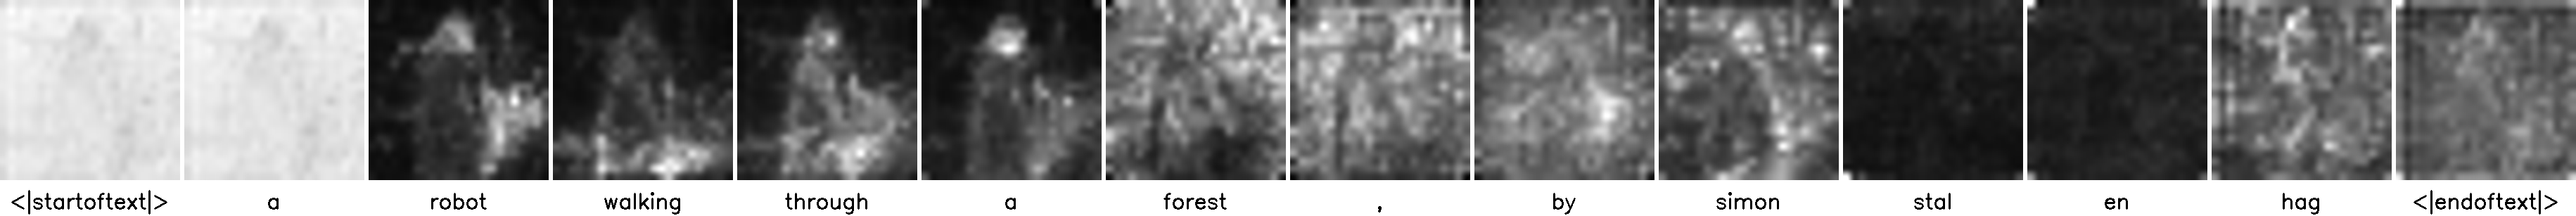

In [ ]:
show_cross_attention(pipe.tokenizer, prompts, attn_controller, 24, "down", 1)

In [1]:
import transformers
from attn_reweigh_solo.attn_reweigh import AttentionJustReweight
import torch
import diffusers
from attn_reweigh_solo.utils import register_attention_control
from attn_reweigh_solo.parse_prompt import get_weighted_text_embeddings


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pipe = diffusers.StableDiffusionPipeline.from_pretrained("darkstorm2150/Protogen_x3.4_Official_Release").to("cuda").to(torch.float16)



Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [12]:
attn_controller.prev_controller.cross_replace_alpha

tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.]]]],



        [[[[1., 1., 1.,  ..., 1., 1., 1.]]]],



        [[[[1., 1., 1.,  ..., 1., 1., 1.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.]]]]], device='cuda:0',
       dtype=torch.float16)

In [151]:
batch_size = 1
num_steps = 50
cross_replace_steps = 0.0
prompt = "a wartorn landscape with a (plane in the sky:3)"

eq = get_weighted_text_embeddings(pipe, prompt)[2]

controller = AttentionJustReweight(
    batch_size, 
    num_steps, 
    cross_replace_steps, 
    eq, device="cuda", 
    dtype=torch.float16, 
    image_size=(512,512), 
    smooth_steps=0.7, 
    active_layers=None,
    #len_active_tokens=12,
    early_boost_steps=0.3,
    sigma=0.8,
    smooth_all_tokens=True,
    kernel_size=3,
    early_boost_factor=4,
norm="mean")





In [152]:
register_attention_control(pipe, controller)

In [153]:
torch.manual_seed(26)
imgs = pipe(prompt, 
            num_inference_steps=50, 
            width=512, 
            height=512).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [155]:
imgs[0].save("./3.png")

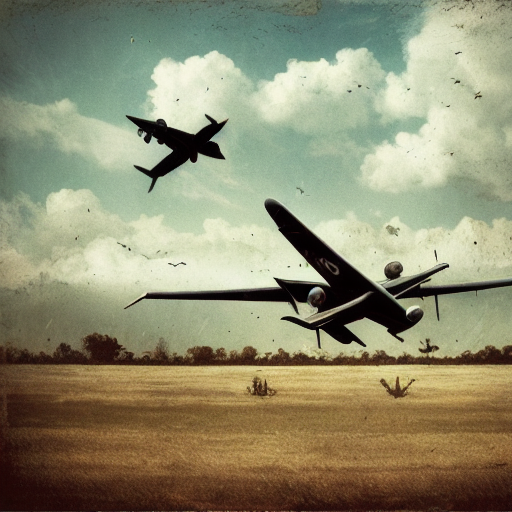

In [126]:
imgs[0]#.save("./1.png")

In [20]:
attn_controller.prev_controller.cross_replace_alpha

tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.]]]],



        [[[[1., 1., 1.,  ..., 1., 1., 1.]]]],



        [[[[1., 1., 1.,  ..., 1., 1., 1.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.]]]]], device='cuda:0',
       dtype=torch.float16)

In [ ]:
pipe.set_attention_slice(8)

In [ ]:
items = [1,2,3,4]

In [ ]:
items[-1]

4

In [8]:
h,w = torch.ones(1,4,64,64).shape[-2:]

64

In [11]:
attn_controller.prev_controller.mapper

tensor([[ 0,  1,  2,  3,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1,  6, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76]], device='cuda:0')

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

In [59]:
from PIL import Image
import numpy as np
import transformers

img = Image.open("./image.png")
npimg = np.asarray(img)
feat_extractor = transformers.CLIPFeatureExtractor.from_pretrained("openai/clip-vit-large-patch14")
img = feat_extractor(imgpil, return_tensors="pt").pixel_values.to("cuda").to(torch.float16)

l = pipe.safety_checker(img, npimg)

In [61]:
l[1]

[False]